### Biblioteca

In [34]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

### Coleta e tratamento dos dados

In [14]:

dados_2021 = pd.read_csv('dados/gripe_2021.csv', sep=';', encoding='ISO-8859-1')
dados_2022 = pd.read_csv('dados/gripe_2022.csv', sep=';', encoding='ISO-8859-1')
dados_2023 = pd.read_csv('dados/gripe_2023.csv', sep=';', encoding='ISO-8859-1')

dados = pd.concat([dados_2021, dados_2022, dados_2023])


/var/folders/z3/2x5_0s3j31zdf3c9g85v3rbc0000gn/T/ipykernel_21832/152469830.py:1: DtypeWarning: Columns (15,59,61,62,63,91,93,105,107,114,116,117,118,122,143) have mixed types. Specify dtype option on import or set low_memory=False.
  dados_2021 = pd.read_csv('dados/gripe_2021.csv', sep=';', encoding='ISO-8859-1')
/var/folders/z3/2x5_0s3j31zdf3c9g85v3rbc0000gn/T/ipykernel_21832/152469830.py:2: DtypeWarning: Columns (15,53,59,61,62,63,91,93,120,122,143,171) have mixed types. Specify dtype option on import or set low_memory=False.
  dados_2022 = pd.read_csv('dados/gripe_2022.csv', sep=';', encoding='ISO-8859-1')
/var/folders/z3/2x5_0s3j31zdf3c9g85v3rbc0000gn/T/ipykernel_21832/152469830.py:3: DtypeWarning: Columns (15,18,20,23,53,59,61,63,72,74,79,91,93,109,130,175,178) have mixed types. Specify dtype option on import or set low_memory=False.
  dados_2023 = pd.read_csv('dados/gripe_2023.csv', sep=';', encoding='ISO-8859-1')


In [15]:
dados.columns

Index(['DT_NOTIFIC', 'SEM_NOT', 'DT_SIN_PRI', 'SEM_PRI', 'SG_UF_NOT',
       'ID_REGIONA', 'CO_REGIONA', 'ID_MUNICIP', 'CO_MUN_NOT', 'ID_UNIDADE',
       ...
       'VG_ENC', 'VG_REINF', 'REINF', 'FAB_ADIC', 'LOT_RE_BI', 'FAB_RE_BI',
       'DOSE_ADIC', 'DOS_RE_BI', 'LOTE_ADIC', 'TABAG'],
      dtype='object', length=190)

In [16]:
# Verificando nulos e inválidos
dados.isna().sum()

DT_NOTIFIC          0
SEM_NOT             0
DT_SIN_PRI          0
SEM_PRI             0
SG_UF_NOT           0
               ...   
FAB_RE_BI     2545509
DOSE_ADIC     2561067
DOS_RE_BI     2545495
LOTE_ADIC     2561129
TABAG         2566070
Length: 190, dtype: int64

In [18]:
# Concatenando os dados
dados = pd.concat([dados_2021, dados_2022, dados_2023])

# Mantendo apenas as colunas relevantes
dados = dados[['DT_NOTIFIC', 'SG_UF_NOT', 'CO_REGIONA', 'CO_MUN_NOT', 'CS_SEXO', 'DT_NASC', 'NU_IDADE_N', 'CS_GESTANT', 'CS_RACA']]

# Ajustando a conversão de datas
dados['DT_NOTIFIC'] = pd.to_datetime(dados['DT_NOTIFIC'], format='%d/%m/%Y')
dados['DT_NASC'] = pd.to_datetime(dados['DT_NASC'], format='%d/%m/%Y', errors='coerce')  # usando errors='coerce' para lidar com qualquer dado incorreto

# Criando metadados
dados['ANO'] = dados['DT_NOTIFIC'].dt.year
dados['MES'] = dados['DT_NOTIFIC'].dt.month

# Convertendo variáveis categóricas em numéricas conforme necessário
dados = pd.get_dummies(dados, columns=['SG_UF_NOT', 'CS_SEXO', 'CS_GESTANT', 'CS_RACA'])

In [22]:
# Removendo linhas onde CO_REGIONA é nulo
dados = dados.dropna(subset=['CO_REGIONA'])
dados = dados.dropna(subset=['DT_NASC'])
print(dados.isnull().sum())

DT_NOTIFIC      0
CO_REGIONA      0
CO_MUN_NOT      0
DT_NASC         0
NU_IDADE_N      0
ANO             0
MES             0
SG_UF_NOT_AC    0
SG_UF_NOT_AL    0
SG_UF_NOT_AM    0
SG_UF_NOT_AP    0
SG_UF_NOT_BA    0
SG_UF_NOT_CE    0
SG_UF_NOT_DF    0
SG_UF_NOT_ES    0
SG_UF_NOT_GO    0
SG_UF_NOT_MA    0
SG_UF_NOT_MG    0
SG_UF_NOT_MS    0
SG_UF_NOT_MT    0
SG_UF_NOT_PA    0
SG_UF_NOT_PB    0
SG_UF_NOT_PE    0
SG_UF_NOT_PI    0
SG_UF_NOT_PR    0
SG_UF_NOT_RJ    0
SG_UF_NOT_RN    0
SG_UF_NOT_RO    0
SG_UF_NOT_RR    0
SG_UF_NOT_RS    0
SG_UF_NOT_SC    0
SG_UF_NOT_SE    0
SG_UF_NOT_SP    0
SG_UF_NOT_TO    0
CS_SEXO_1       0
CS_SEXO_F       0
CS_SEXO_I       0
CS_SEXO_M       0
CS_GESTANT_0    0
CS_GESTANT_1    0
CS_GESTANT_2    0
CS_GESTANT_3    0
CS_GESTANT_4    0
CS_GESTANT_5    0
CS_GESTANT_6    0
CS_GESTANT_9    0
CS_RACA_1.0     0
CS_RACA_2.0     0
CS_RACA_3.0     0
CS_RACA_4.0     0
CS_RACA_5.0     0
CS_RACA_9.0     0
dtype: int64


### Separando previsores e alvo

In [24]:
# Para este exemplo, vou considerar apenas a contagem de casos, mas você precisa ajustar para o seu caso específico
dados_agregados = dados.groupby(['ANO', 'MES', 'CO_REGIONA']).size().reset_index(name='CASOS')
previsores = dados_agregados.drop('CASOS', axis=1)
alvo = dados_agregados['CASOS']

### Escalonando

In [28]:
scaler = StandardScaler()
previsores = scaler.fit_transform(previsores)

### Divisão Treino Teste 70 - 30

In [30]:
X_train, X_test, y_train, y_test = train_test_split(previsores, alvo, test_size=0.3, random_state=42)

### Loop algoritimo

In [32]:

modelos = {
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'KNN': KNeighborsRegressor(),
    'MLP': MLPRegressor(max_iter=500)  # Aumentando o número de iterações para garantir a convergência
}

for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    predicoes = modelo.predict(X_test)
    mse = mean_squared_error(y_test, predicoes)
    print(f'{nome} MSE: {mse}')


RandomForest MSE: 110659.7296188779
GradientBoosting MSE: 176512.59919166498
KNN MSE: 468669.9216105611
MLP MSE: 485326.9543051704


/Users/rafaelmunareto/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


### Criação de hibirdos

In [33]:
rf = RandomForestRegressor().fit(X_train, y_train)
gb = GradientBoostingRegressor().fit(X_train, y_train)

pred_rf = rf.predict(X_test)
pred_gb = gb.predict(X_test)

pred_hibrido = (pred_rf + pred_gb) / 2
mse_hibrido = mean_squared_error(y_test, pred_hibrido)
print(f'Híbrido MSE: {mse_hibrido}')

Híbrido MSE: 133970.41333955067


### Resultado

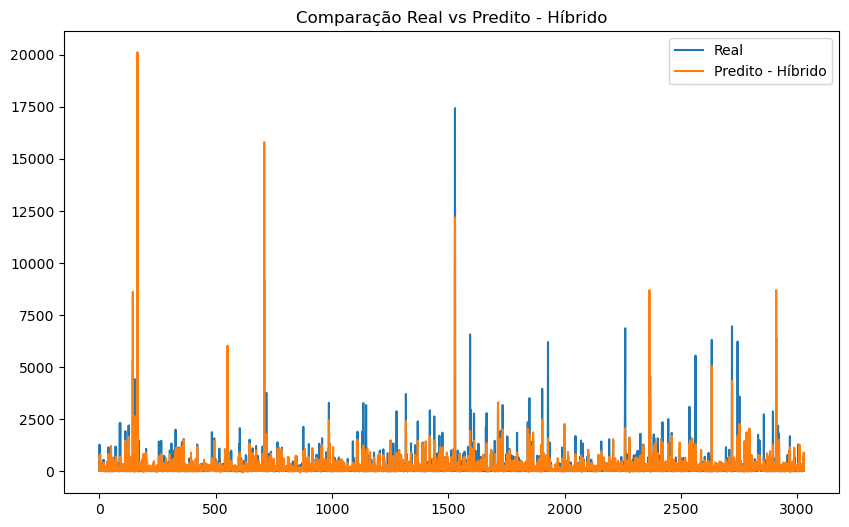

In [35]:

plt.figure(figsize=(10, 6))
plt.plot(y_test.reset_index(drop=True), label='Real')
plt.plot(pred_hibrido, label='Predito - Híbrido')
plt.title('Comparação Real vs Predito - Híbrido')
plt.legend()
plt.show()